# Abstractive Text Summarization
#team memebers
  PES1UG19CS110 BHAVANA YADAV K

PES1UG19CS124 CHARUSHREE A

PES1UG19CS463 SHREYA VISHWAS


**There 2 different training models used here**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.


In [ ]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [ ]:

!pip install -q contractions


     |████████████████████████████████| 287 kB 4.9 MB/s 
     |████████████████████████████████| 106 kB 52.8 MB/s 


In [ ]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [ ]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.45.14.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.45.14.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## 🪂 Getting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:




filename1 = "/content/drive/MyDrive/AIWR_PROJECT/AIWR_PROJECT/csv/news_summary.csv"
filename2 = "/content/drive/MyDrive/AIWR_PROJECT/AIWR_PROJECT/csv/news_summary_more.csv"
df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [ ]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
1100,Rini Sinha,"19 Feb 2017,Sunday",Saif's daughter Sara replaces Disha Patani in ...,http://indiatoday.intoday.in/story/tiger-shrof...,Saif Ali Khan's daughter Sara has reportedly r...,Earlier there were reports that Tiger Shroff's...
2922,Prashanti Moktan,"21 Jun 2017,Wednesday",Bipasha performs yoga asanas with her husband ...,http://indiatoday.intoday.in/story/internation...,Actress Bipasha Basu has shared pictures of he...,Bipasha Basu and Karan Singh Grover are one of...
2920,Prashanti Moktan,"21 Jun 2017,Wednesday","Akshay is bigger star than Khans in Bollywood,...",http://indiatoday.intoday.in/story/salman-khan...,Salman Khan has referred to Akshay Kumar as th...,He is one of Bollywood's biggest stars. If his...
2136,Chhavi Tyagi,"09 Dec 2016,Friday","Sheena Bora murder accused demands laptop, dry...",http://indiatoday.intoday.in/story/sheena-bora...,Sheena Bora murder accused Peter Mukerjea has ...,Former media baron Peter Mukerjea wants to wri...
4329,Prashanti Moktan,"08 Mar 2017,Wednesday",Wish women give men as much happiness as Sunny...,http://indiatoday.intoday.in/story/ram-gopal-v...,Filmmaker Ram Gopal Varma on the occasion of I...,"Ram Gopal Varma, filmmaker and enfant terrible..."


In [ ]:
df2.sample(5)

,headlines,text
38992,New Roadsters to have SpaceX-inspired rocket t...,Electric carmaker Tesla's CEO Elon Musk has sa...
76585,Anushka features on cover of Elle India's Augu...,Actress Anushka Sharma has featured on the cov...
60152,Bond villain comparison a compliment: US Treas...,US Treasury Secretary Steven Mnuchin has said ...
92235,Tarantulas rely on side-eyes to navigate back ...,Spain-based researchers have found that tarant...
34629,IPL witnesses 2nd ton in 2 days after no ton i...,Indian Premier League 2018 witnessed its secon...


In [ ]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
80887,Pune girl forced to keep Ã¢ÂÂgod-givenÃ¢ÂÂ...,An incident of a 12-year-old Pune girl maintai...
54296,Deutsche Bank 'accidentally' sent $35 billion ...,Germany's biggest lender Deutsche Bank last mo...
94676,"Doklam an old page, hoping to work with India:...",China's Consul General Ma Zhanwu on Tuesday sa...
10869,"Tanzania pardons rapists, calls for arrest of ...",Tanzanian President John Magufuli pardoned the...
7433,Parliament not immune to casting couch: Renuka...,"Speaking about the practice of casting couch, ..."


The `headlines` column will be treated as `summary` for the text.

## 🏂 Data preparation

In [ ]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all cannot expand contractions id think'

In [ ]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
42997,i have an issue with cbfc's favouritism: tigma...,filmmaker tigmanshu dhulia has said he has no ...
6201,new jrr tolkien love story released after 100 ...,a new middle-earth love story by 'lord of the ...
19753,"i'm at mercy of congress, not 6.5 crore people...",karnataka cm hd kumaraswamy has said he's at t...
15180,how can you touch one's genitals: sc on mutila...,while hearing a pil seeking ban on 'khatna' or...
9395,'america first' does not mean america alone: t...,us president donald trump on friday said that ...


In [ ]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
44640,j&k cops ask pak high commission to claim let ...,jammu and kashmir police have approached the p...
86932,"man city post 4-0 win, extend record win strea...",prthemier league leaders manchester city exten...
3714,over 92% kurds vote in favour of independence ...,over 92% kurds voted in favour of independence...
562,malinga becomes 2nd highest wicket-taker in ic...,sri lankan pacer lasith malinga on monday beca...
45403,pope francis performs his 1st mid-flight iage ...,pope francis performed a wedding certhemony fo...


In [ ]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [ ]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [ ]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
32833,ghost lives yearold bungalow warangal collector,urban collector warangal telangana amrapali ka...
30358,know drive know make films sanjay,filmmaker sanjay leela bhansali said know use ...
59232,ibm loses aaa1 crore valuation buffett drops s...,shares tech giant ibm dropped friday around wi...
2791,n korea think twice us strikes defector,north korea hesitate strike south korea us lau...
78548,video young girl steals pope franciss skullcap,video young girl themerged steals pope francis...


In [ ]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [ ]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

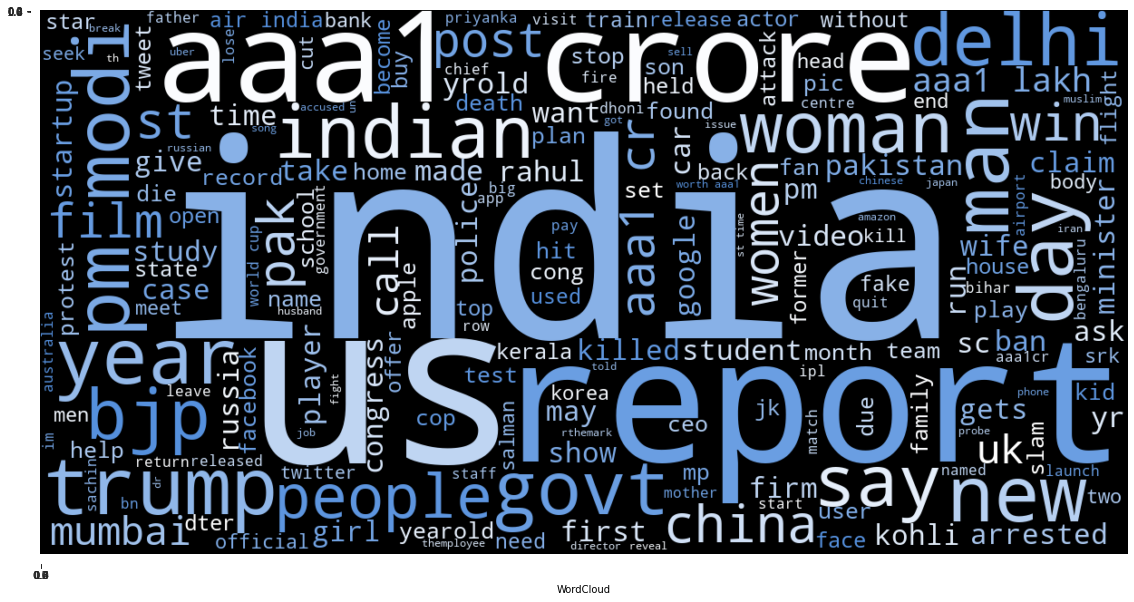

In [ ]:

plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

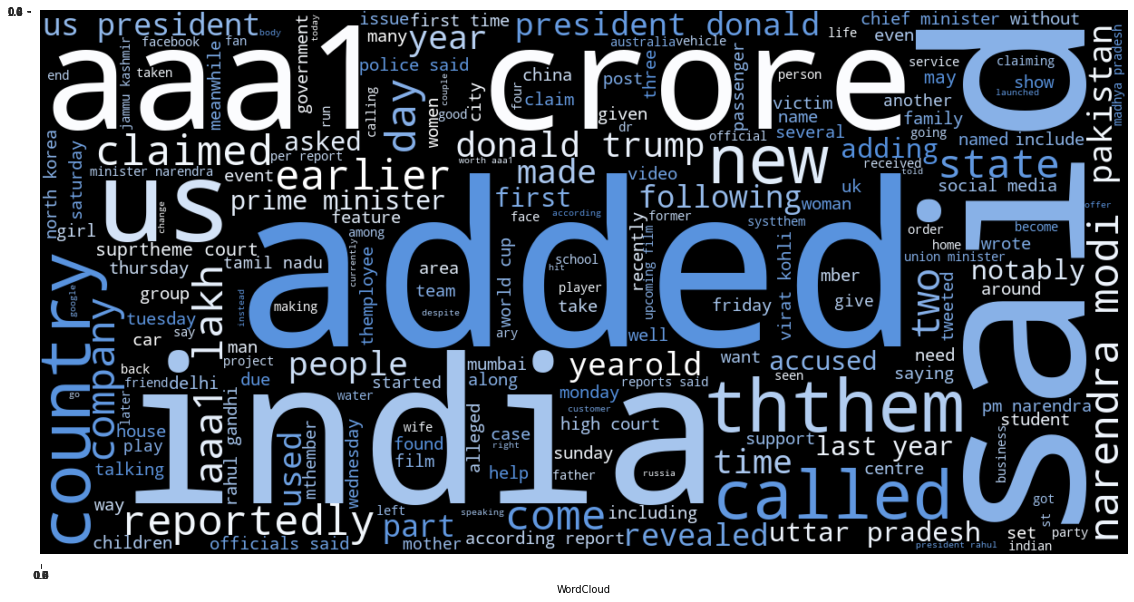

In [ ]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [ ]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

Again adding `tokens` ... but different ones.

In [ ]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

It's important to use `sostok` and `eostok` as start and end tokens respectively as later while using `tensorflow's Tokenizer` will filter the tokens and covert them to lowercase.

**sostok** & **eostok** tokens are for us to know where to start & stop the summary because using `_START_` & `_END_`, tf's tokenizer with convert them to **start** & **end** respectively.

So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use `_START_` & `_END_` tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this) whome tf's tokenizer will convert to start and end then we will stop decoding as we hit first **end**, so this is bad and therefore **sostok** & **eostok** these tokens are used.

So we can just use these **sostok** & **eostok** instead of `_START_` & `_END_`, well you can but I tried both ways and while not using these `_START_` & `_END_` I was getting `undesired results` 🤯 😅 i.e. model's `results weren't good`.

In [ ]:
df.sample(5)

,headlines,text
23970,sostok _START_ maoists blow bjp mps farmhouse ...,maoists blew bjp mp vikram usendis farmhouse u...
20930,sostok _START_ dutch startup makes clothes cow...,dutch startup named bioart laboratories making...
90564,sostok _START_ neycalls barcelona president ba...,brazilian football player neyjr called current...
90929,sostok _START_ mans th wife sets rd fire divor...,fourth wife man madhya pradesh set third one f...
79684,sostok _START_ government set observatories mo...,ministry earth sciences said new seismological...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

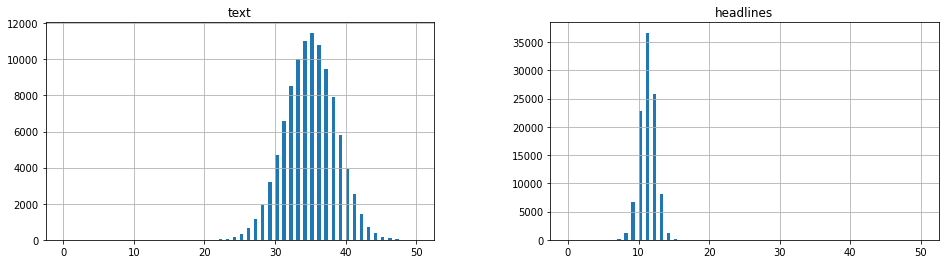

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [ ]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


If the length of headlines or the text is kept large the deep learning model will face issues with performance and also training will slower.

One solution for creating summary for long sentences can be break a paragraph into sentences and then create a summary for them, this way the summary will make sence instead of giving random piece of text and creating summary for it.

In [ ]:
max_text_len = 42
max_summary_len = 13

In [ ]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 100235


,text,summary
44205,responding us defence departments sion cancel ...,sostok _START_ us owes money us pakistan aaa1c...
54646,worlds topranked test batsman steve smith name...,sostok _START_ steve smith named icc test cric...
36474,wal filed patent describes drones summoned cus...,sostok _START_ wal patents show carts drone sh...
22497,first ukbased scientists put precise timings h...,sostok _START_ scientists track st precise tim...
5016,thai government threatened shut access faceboo...,sostok _START_ thailand threatens facebook kin...


In [ ]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [ ]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=1,shuffle=True)

**Tokenizing text 👉 x**

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.35, 'total_coverage': 2.95, 'count': 65219, 'total_count': 99806}


🔥 to `increase computation speed` use this

```python
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])
```

In [ ]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

99807


In [ ]:
print(x_tokenizer.texts_to_sequences("bangalore is beautiful\n  bangalore cherry blossom rainy days"))

[[29529], [], [1839], [25074], [], [2530], [], [20434], [30299], [], [], [], [], [29529], [30299], [], [28238], [], [], [30030], [28238], [2530], [], [], [], [29529], [], [1839], [25074], [], [2530], [], [20434], [30299], [], [25869], [2541], [30299], [20434], [20434], [], [], [29529], [2530], [], [], [], [], [], [], [20434], [], [], [1839], [], [], [], [], [], []]


**Tokenizing headlines(summary) 👉 y**

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 69.06, 'total_coverage': 4.78, 'count': 25814, 'total_count': 37379}


🔥 to `increase computation speed` use this

```python
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])
```

In [ ]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37380


In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## 🤼‍♂️ Modelling


In [ ]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [ ]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '/content/drive/MyDrive/AIWR_PROJECT/AIWR_PROJECT/globe/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 55279 words (44527 misses)
Found 400000 word vectors.
Converted 27006 words (10373 misses)


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(99807, 300)
(37380, 300)


Using `pre-trained` embeddings and keeping the `Embedding` layer `non-trainable` we get increase in computation speed as don't need to compute the embedding matrix.

**Here there 2 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.


**Inference methods for the 2 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`

**Decoding sequence for the 2 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`


**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [ ]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

[link text](https://)**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)
        
        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 300)      29942100    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 42, 240),    519360      ['embedding[0][0]']              
                                 (None, 240),                                                 

If you want to change `model` then just change the `function name` above.

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

Use a `tuple` instead of `list` in `validation_parameter` in `model.fit()`, to know the reason reading this [post](https://stackoverflow.com/questions/61586981/valueerror-layer-sequential-20-expects-1-inputs-but-it-received-2-input-tensor).

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 54s 331ms/step - loss: 6.0356 - accuracy: 0.2997 - val_loss: 5.0919 - val_accuracy: 0.4317 - lr: 0.0010
Epoch 2/50
89/89 [==============================] - 9s 100ms/step - loss: 5.1734 - accuracy: 0.4191 - val_loss: 4.9454 - val_accuracy: 0.4354 - lr: 0.0010
Epoch 3/50
89/89 [==============================] - 9s 100ms/step - loss: 5.0027 - accuracy: 0.4228 - val_loss: 4.7239 - val_accuracy: 0.4403 - lr: 0.0010
Epoch 4/50
89/89 [==============================] - 9s 100ms/step - loss: 4.7770 - accuracy: 0.4285 - val_loss: 4.4990 - val_accuracy: 0.4487 - lr: 0.0010
Epoch 5/50
89/89 [==============================] - 9s 100ms/step - loss: 4.5278 - accuracy: 0.4370 - val_loss: 4.2906 - val_accuracy: 0.4550 - lr: 0.0010
Epoch 6/50
89/89 [==============================] - 9s 99ms/step - loss: 4.3224 - accuracy: 0.4436 - val_loss: 4.1426 - val_accuracy: 0.4612 - lr: 0.0010
Epoch 7/50
89/89 [==============================] - 9s 100ms/step - lo

**Plotting model's performance**

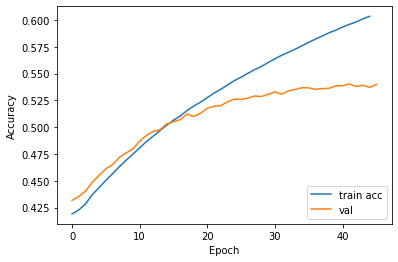

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

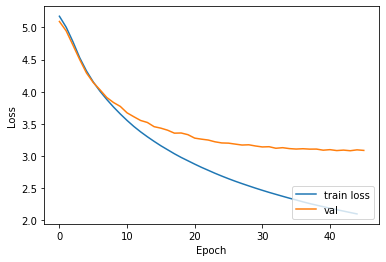

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## 🤸‍♂️ Inference


In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get 
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding (Embedding)       (None, 42, 300)           29942100  
                                                                 
 lstm (LSTM)                 [(None, 42, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 42, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 30,923,220
Trainable params: 981,120
Non-trai

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    11214000    ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

In [ ]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [ ]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text(text)  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [ ]:
predict_text("drunk passenger threatened punch qantas themployee snatched intercom another flight perth brisbane australia fined aaa1 lakh following actions pilot ded turn plane around plane landed perth attthempted bite police officer trying detain ",decode_sequence_seq2seq_model_with_bidirectional_lstm,encoder_model,decoder_model)

' sostok releases govt airways inquiry work nothing start india end end end'

## 🔮 Predictions

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )


# 1 News:  former australian opener matthew hayden participated sixhitting competition exchennai super kings teammate ms dhoni chennai saturday australians team defeating dhonis side dhoni hit three consecutive sixes player either side hit six ball csk players lakshmipathy balaji mohit sharma also participated contest 
Original summary:  start dhonis side defeated haydens team hitting contest end 
Predicted summary:   start dhoni hit indian player hit sixes end
# 2 News:  russian tennis player sharapova first grand slam match since doping suspension sidelined months fivetime grand slam winner defeated world number simona halep maintaining perfect headtohead record romanian sharapovas last grand slam appearance came australian open ary went quarterfinals 
Original summary:  start sharapova wins first grand slam match since doping ban end 
Predicted summary:   start sharapova st player wins st wimbledon match end
# 3 News:  crackdown drunken driving delhi traffic police saturday fined er

In [ ]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
  

# 1 News:  income tax department conducted raids locations chennai coimbatore connection tax evasion probe realty business holders saravana stores residence saravana stores owner also raided earlier department conducted raids number popular eateries tamil nadu including saravana bhavan outlets 
Original summary:  start raids conducted places chennai coimbatore end 
Predicted summary:   start raids raids karnataka hotels raided tax evasion end
# 2 News:  ranveer singh sara ali khan starrer simmba released today winner wrote bollywood hungama film potboiler expect said times india toi hindustan times ht praised ranveers performance wrote lifts rated bollywood hungama toi ht 
Original summary:  start ranveer singh sara ali khan starrer simmba hits theatres end 
Predicted summary:   start ranveer singh starrer release date film release end
# 3 News:  video surfaced shows barcelonas newlywed argentine forward lionel messi dancing wife antonella roccuzzo argentina teammate sergio aguero mess

## 🎁 Saving the model

In [ ]:

model.save('model.h5')    
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

## 🏌️‍♂️ Running  2 different models

After understanding how all the pieces work, running all the `2 models` to understand how it `performs` and its `results`.

**Here there 2 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

**Inference methods for the 2 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`


**Decoding sequence for the 2 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`

In [ ]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    }
}

**Model with just LSTMs**

In [ ]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 42, 300)      29932200    ['input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 42, 240),    519360      ['embedding_2[0][0]']            
                                 (None, 240),                                               

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 54s 338ms/step - loss: 6.0246 - accuracy: 0.3039 - val_loss: 5.1066 - val_accuracy: 0.4317 - lr: 0.0010
Epoch 2/50
89/89 [==============================] - 9s 102ms/step - loss: 5.1732 - accuracy: 0.4190 - val_loss: 4.9158 - val_accuracy: 0.4354 - lr: 0.0010
Epoch 3/50
89/89 [==============================] - 9s 101ms/step - loss: 5.0028 - accuracy: 0.4228 - val_loss: 4.7565 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 4/50
89/89 [==============================] - 9s 100ms/step - loss: 4.7684 - accuracy: 0.4292 - val_loss: 4.5261 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 5/50
89/89 [==============================] - 10s 107ms/step - loss: 4.5135 - accuracy: 0.4376 - val_loss: 4.3174 - val_accuracy: 0.4527 - lr: 0.0010
Epoch 6/50
89/89 [==============================] - 9s 102ms/step - loss: 4.3090 - accuracy: 0.4441 - val_loss: 4.1423 - val_accuracy: 0.4608 - lr: 0.0010
Epoch 7/50
89/89 [==============================] - 9s 102ms/step - 

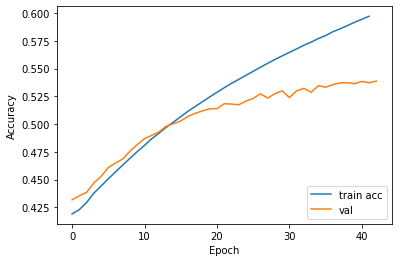

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

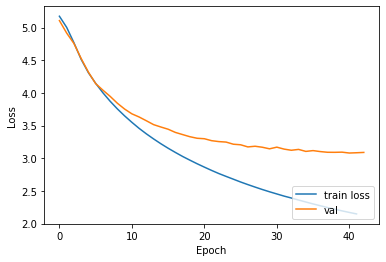

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 42, 300)           29932200  
                                                                 
 lstm_3 (LSTM)               [(None, 42, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_4 (LSTM)               [(None, 42, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 30,913,320
Trainable params: 981,120
Non-trai

In [ ]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 300)    11216700    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  former australian opener matthew hayden participated sixhitting competition exchennai super kings teammate ms dhoni chennai saturday australians team defeating dhonis side dhoni hit three consecutive sixes player either side hit six ball csk players lakshmipathy balaji mohit sharma also participated contest 
Original summary:  start dhonis side defeated haydens team hitting contest end 
Predicted summary:   start dhoni congratulates ms dhoni brothers champions trophy end

# 2 News:  russian tennis player sharapova first grand slam match since doping suspension sidelined months fivetime grand slam winner defeated world number simona halep maintaining perfect headtohead record romanian sharapovas last grand slam appearance came australian open ary went quarterfinals 
Original summary:  start sharapova wins first grand slam match since doping ban end 
Predicted summary:   start sharapova wins first time since doping ban end

# 3 News:  crackdown drunken driving delhi traffic po

**Model with Bidirectional LSTMs**

In [ ]:

model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 42)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 42, 300)      29932200    ['input_11[0][0]']               
                                                                                                  
 encoder_bidirectional_lstm_1 (  [(None, 42, 480),   1038720     ['encoder_embedding[0][0]']      
 Bidirectional)                  (None, 240),                                                     
                                 (None, 240),                                                     
                                 (None, 240),                 

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 101s 608ms/step - loss: 5.4519 - accuracy: 0.3837 - val_loss: 4.3617 - val_accuracy: 0.4585 - lr: 0.0010
Epoch 2/50
89/89 [==============================] - 18s 205ms/step - loss: 4.0127 - accuracy: 0.4807 - val_loss: 3.2930 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 3/50
89/89 [==============================] - 18s 205ms/step - loss: 3.1015 - accuracy: 0.5705 - val_loss: 2.4875 - val_accuracy: 0.6397 - lr: 0.0010
Epoch 4/50
89/89 [==============================] - 18s 206ms/step - loss: 2.4104 - accuracy: 0.6585 - val_loss: 1.9238 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 5/50
89/89 [==============================] - 18s 205ms/step - loss: 1.9079 - accuracy: 0.7297 - val_loss: 1.5234 - val_accuracy: 0.7813 - lr: 0.0010
Epoch 6/50
89/89 [==============================] - 18s 205ms/step - loss: 1.5382 - accuracy: 0.7840 - val_loss: 1.2473 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 7/50
89/89 [==============================] - 18s 206ms/s

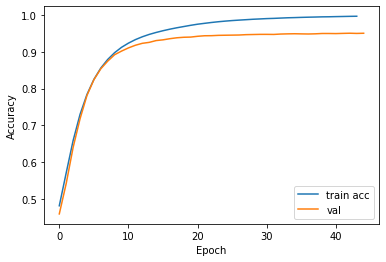

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

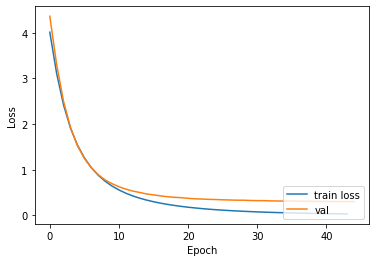

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 42)]              0         
                                                                 
 encoder_embedding (Embeddin  (None, 42, 300)          29932200  
 g)                                                              
                                                                 
 encoder_bidirectional_lstm_  [(None, 42, 480),        1038720   
 1 (Bidirectional)            (None, 240),                       
                              (None, 240),                       
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 encoder_bidirectional_lstm_  [(None, 42, 480),        1384320   
 2 (Bidirectional)            (None, 240),                 

In [ ]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 300)    11216700    ['input_12[0][0]']               
                                                                                                  
 input_13 (InputLayer)          [(None, 240)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 240)]        0           []                               
                                                                                            

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  former australian opener matthew hayden participated sixhitting competition exchennai super kings teammate ms dhoni chennai saturday australians team defeating dhonis side dhoni hit three consecutive sixes player either side hit six ball csk players lakshmipathy balaji mohit sharma also participated contest 
Original summary:  start dhonis side defeated haydens team hitting contest end 
Predicted summary:   end end end end end end end end end end end end

# 2 News:  russian tennis player sharapova first grand slam match since doping suspension sidelined months fivetime grand slam winner defeated world number simona halep maintaining perfect headtohead record romanian sharapovas last grand slam appearance came australian open ary went quarterfinals 
Original summary:  start sharapova wins first grand slam match since doping ban end 
Predicted summary:   end end end end end end end end end end end end

# 3 News:  crackdown drunken driving delhi traffic police saturday fined er